In [28]:
pip install yellowbrick

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 1.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Unsupervised Learning Overview

To begin this task, we first wanted to explore clustering to see if we could identify potential voting patterns among precincts based on Presidential Turnout for the 2016 and 2020 elections. Given that this involved six different columns of data, we employed Principal Component Analysis (PCA) for dimensionality reduction. The optimal number of clusters was determined using an elbow plot, and the quality of the clustering was further evaluated using Silhouette Analysis.

In [144]:
columns_to_use = [
    'AGE' ,'CNSUS_PCTA',
    'CNSUS_PCTH', 'CNSUS_PCTM', 'CNSUS_PCTO',  'CNSUS_PCTW',
     'EDUCATION', 'ETHNIC_INFER', 'ETHNICGRP',
   'NETWORTH',  "COUNTY_ST",
    'PARTY_CODE',  'PRESENCHLD', 
    'RELIGION',  "CENSUS_TRK",
    'TOD_PRES_D_2016',  'TOD_PRES_D_2020_PREC', 
    'TOD_PRES_R_2016', 'TOD_PRES_R_2016_PREC','TOD_PRES_DIFF_2016','TOD_PRES_DIFF_2020_PREC','TOD_PRES_DIFF_2016_PREC',
    'TOD_PRES_R_2020_PREC',
    'TOD_PRES_DIFF_2016_party','TOD_PRES_DIFF_2016_decimal','TOD_PRES_DIFF_2016_PREC_decimal',"TOD_PRES_DIFF_2016_PREC_party",
  'TOD_PRES_DIFF_2020_PREC_party','TOD_PRES_DIFF_2020_PREC_decimal', 'AI_COUNTY_NAME',
         "CREDRATE","HH_SIZE",
    "PRFL_BORDER_SECURITY", "PRFL_CHOICELIFE", "PRFL_CONSERVATIVE_NEWS", "PRFL_TRUMP_SUPPORT",
 "PRFL_IMMIGRATION_REFORM", "VTR_GEN20" ,"VTR_GEN21","VTR_GEN22",
 "VTR_OTH09", "VTR_OTH17", "VTR_PPP04", "VTR_PPP08", "VTR_PPP12", "VTR_PPP16", "VTR_PPP20","PARTY_MIX",
 "PRFL_MARRIAGE_EQUALITY", "ADD_TYPE", "PRFL_HEALTHCARE_REFORM","PRFL_BLM_SUPPORT",
  "PRFL_LIBERAL_NEWS", "PRFL_LGBT_SUPPORT",'PRFL_POLITICAL_IDEOLOGY',"PRFL_ACTIVE_MIL",'STATE',"COUNTY_TYPE"]

In [148]:


from preprocessing_utils import *
from candidatemodeler import *
import pandas as pd
import numpy as np
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score


seed = 42
np.random.seed(seed)

survey_data_path = "/Volumes/DeepLearner/MADS/Milestone_data/surveydata.csv"
data_5k_path = "/Volumes/DeepLearner/MADS/Milestone_data/data_500k.csv"
config_path = "/Volumes/DeepLearner/MADS/Milestone2_Party_prediction/milestone2_MADS/preprocessing_config.json"

surveydata = pd.read_csv(survey_data_path, low_memory=False)
preprocessor_survey = DataPreprocessor(surveydata, is_training=True,config_path=config_path)
survey_df = preprocessor_survey.run_preprocessing_pipeline(skip_preprocess_dataframe=True, use_frequency_encoding=True, drop_converted_cols=True)
survey_df, columns_to_use = feature_engineering_voting_data(survey_df, columns_to_use, extend_columns=True)


Loading config from /Volumes/DeepLearner/MADS/Milestone2_Party_prediction/milestone2_MADS/preprocessing_config.json
DataPreprocessor initialized.
Bleep bloop...
Applying config...
Standardizing missing values...
Imputing missing values...
Hang in there, still sweeping the floor...
Imputing missing values...
Hang in there, still sweeping the floor...
Imputing missing values...
Hang in there, still sweeping the floor...
Mapping categorical values...
Oh smokes, forgot to make the bed...
Engineering new features...
Preprocessing turnout columns...
Voila! cleaning chores have finished, time to explore!


In [9]:
# grab list of numeric columns
numeric_cols = survey_df.select_dtypes(include=np.number).columns.tolist()

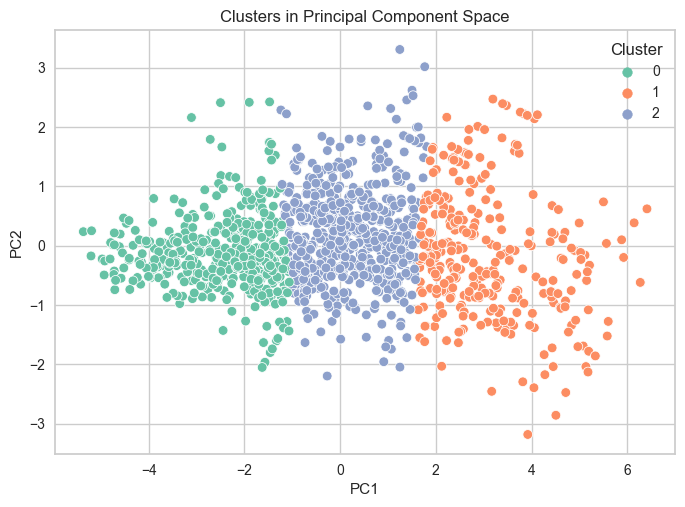

In [149]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


turn_out_df = survey_df[['TOD_PRES_D_2016', 'TOD_PRES_D_2016_PREC', 
                         'TOD_PRES_D_2020_PREC', 'TOD_PRES_R_2016', 
                         'TOD_PRES_R_2016_PREC', 'TOD_PRES_R_2020_PREC']]


# Standardize the data if not done yet
scaler = StandardScaler()
scaled_turn_out_df = scaler.fit_transform(turn_out_df)

# Fit 2 PCA components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_turn_out_df)

# Now cluster the data using PCA components
kmeans = KMeans(n_clusters=3)
kmeans.fit(principal_components)

# Get cluster assignments
labels = kmeans.labels_

# Create a DataFrame for plotting
df_plot = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
df_plot['Cluster'] = labels

# Scatter plot
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title('Clusters in Principal Component Space')
plt.show()





In [152]:
import plotly.express as px
import pandas as pd

def plot_cluster_distribution(survey_df, state_col='State', cluster_col='Cluster'):
    """
    Plot a choropleth map showing the ratio of clusters by state.

    Parameters:
    - survey_df: DataFrame containing the original data along with cluster labels
    - state_col: Column name that contains the state labels
    - cluster_col: Column name that contains the cluster labels
    """

    # Group by state and cluster, and count the number of occurrences
    grouped_df = survey_df.groupby([state_col, cluster_col]).size().reset_index(name='count')
    
    # Calculate the total count for each state
    total_count_df = grouped_df.groupby([state_col]).agg({'count': 'sum'}).reset_index()
    total_count_df.rename(columns={'count': 'total_count'}, inplace=True)

    # Merge to get ratio
    merged_df = pd.merge(grouped_df, total_count_df, on=state_col)
    merged_df['ratio'] = merged_df['count'] / merged_df['total_count']

    # Plotting using Plotly
    fig = px.choropleth(merged_df, 
                        locations=state_col, 
                        color='ratio',
                        hover_name=state_col, 
                        locationmode="USA-states",
                        scope="usa",
                        title="Distribution of Clusters by State",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        animation_frame=cluster_col)
        
    fig.show()

# Assuming 'State' is the column name for states in your survey_df
plot_cluster_distribution(survey_df, state_col='STATE', cluster_col='Cluster')


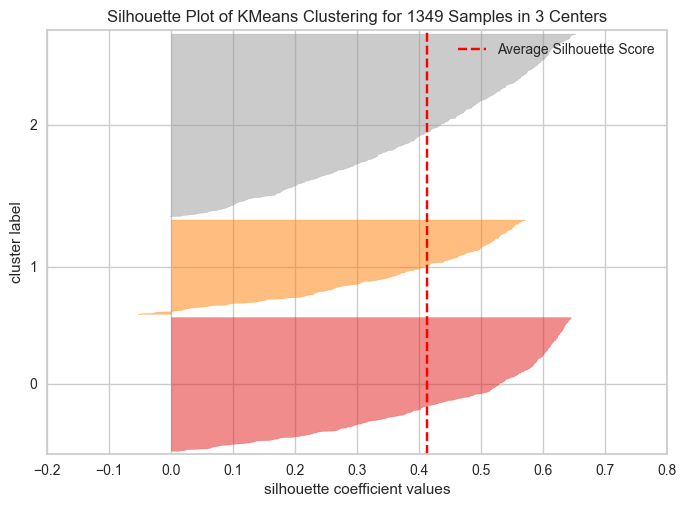

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1349 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [153]:
# Create the visualizer with the K-means model
visualizer = SilhouetteVisualizer(kmeans)

# Fit the data and show the plot
visualizer.fit(principal_components)
visualizer.show()


In [154]:
# Calculate Silhouette score
sil_score = silhouette_score(principal_components, labels)
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.41319557434518517


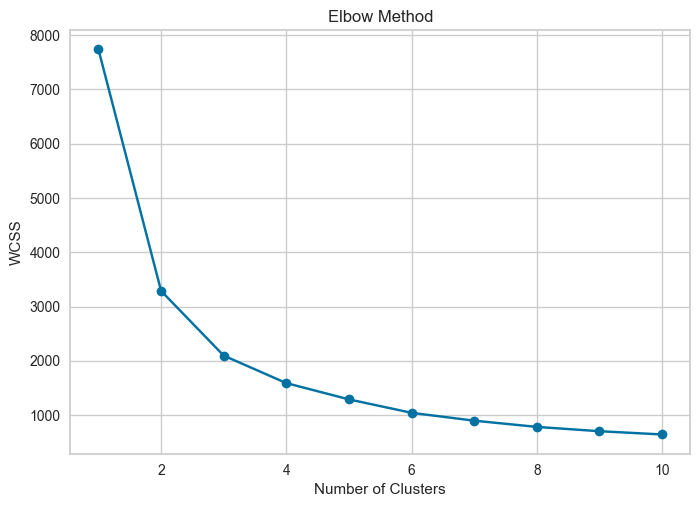

In [155]:
# Elbow Method
wcss = []  # within-cluster sum of squares
for i in range(1, 11):
    kmeans_i = KMeans(n_clusters=i, random_state=0)
    kmeans_i.fit(principal_components)
    wcss.append(kmeans_i.inertia_)

# Plotting
plt.figure()
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


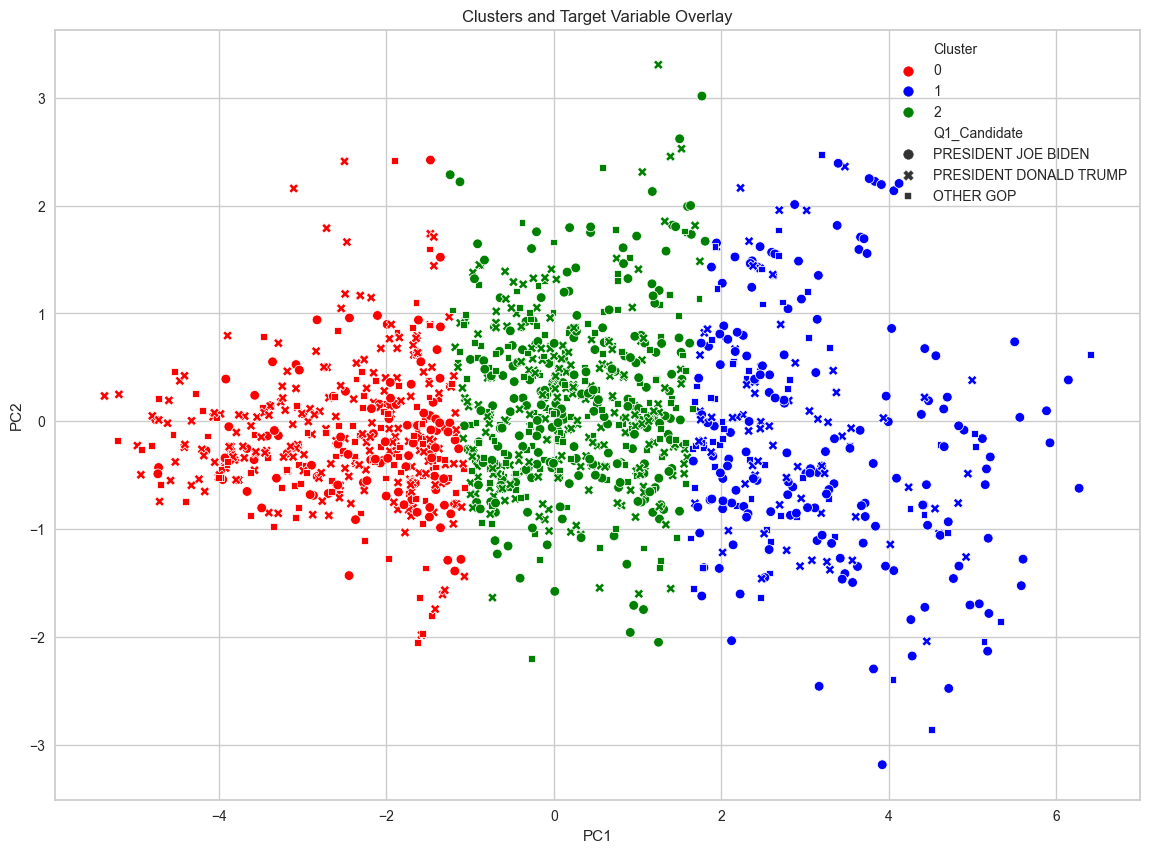

In [159]:
# Adding the target variable to your plotting DataFrame
df_plot['Q1_Candidate'] = survey_df['Q1_Candidate'].values
cluster_centers = kmeans.cluster_centers_

# Create a custom color map
custom_palette = {0: 'red', 1: 'blue', 2: 'green'}

plt.figure(figsize=(14, 10))

# Scatter plot for clusters
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Cluster', style='Q1_Candidate', palette=custom_palette)

plt.title('Clusters and Target Variable Overlay')
plt.legend(loc='upper right', fontsize='small')

plt.show()


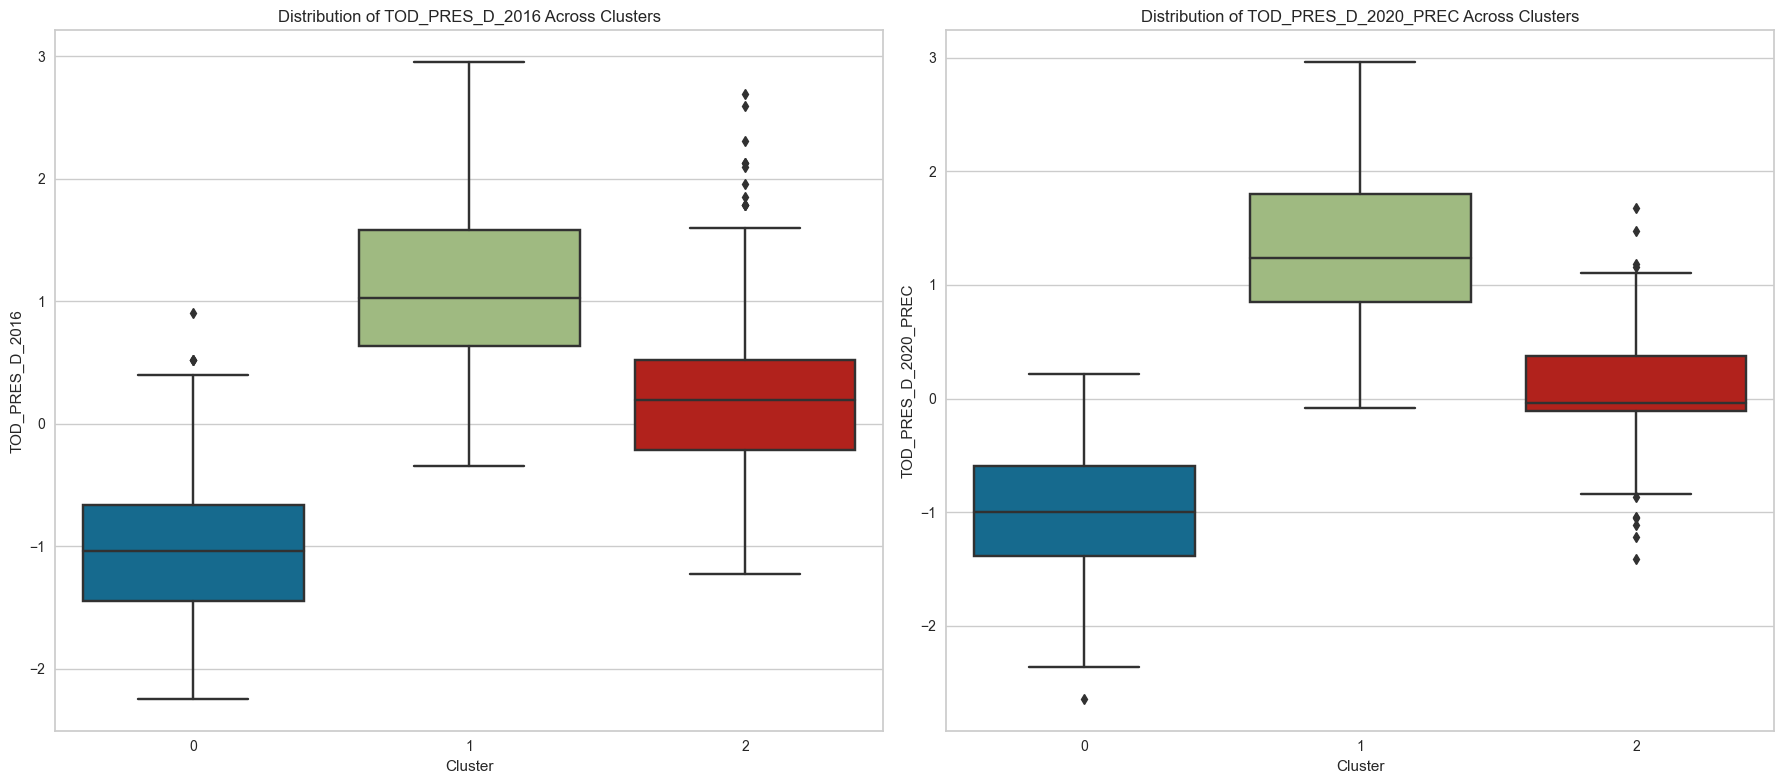

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Add cluster labels to the original standardized DataFrame
scaled_turn_out_df_with_labels = pd.DataFrame(scaled_turn_out_df, columns=turn_out_df.columns)
scaled_turn_out_df_with_labels['Cluster'] = labels
# Boxplot for 2016
sns.boxplot(data=scaled_turn_out_df_with_labels, x='Cluster', y='TOD_PRES_D_2016', ax=axes[0])
axes[0].set_title('Distribution of TOD_PRES_D_2016 Across Clusters')

# Boxplot for 2020
sns.boxplot(data=scaled_turn_out_df_with_labels, x='Cluster', y='TOD_PRES_D_2020_PREC', ax=axes[1])
axes[1].set_title('Distribution of TOD_PRES_D_2020_PREC Across Clusters')

plt.tight_layout()
plt.show()


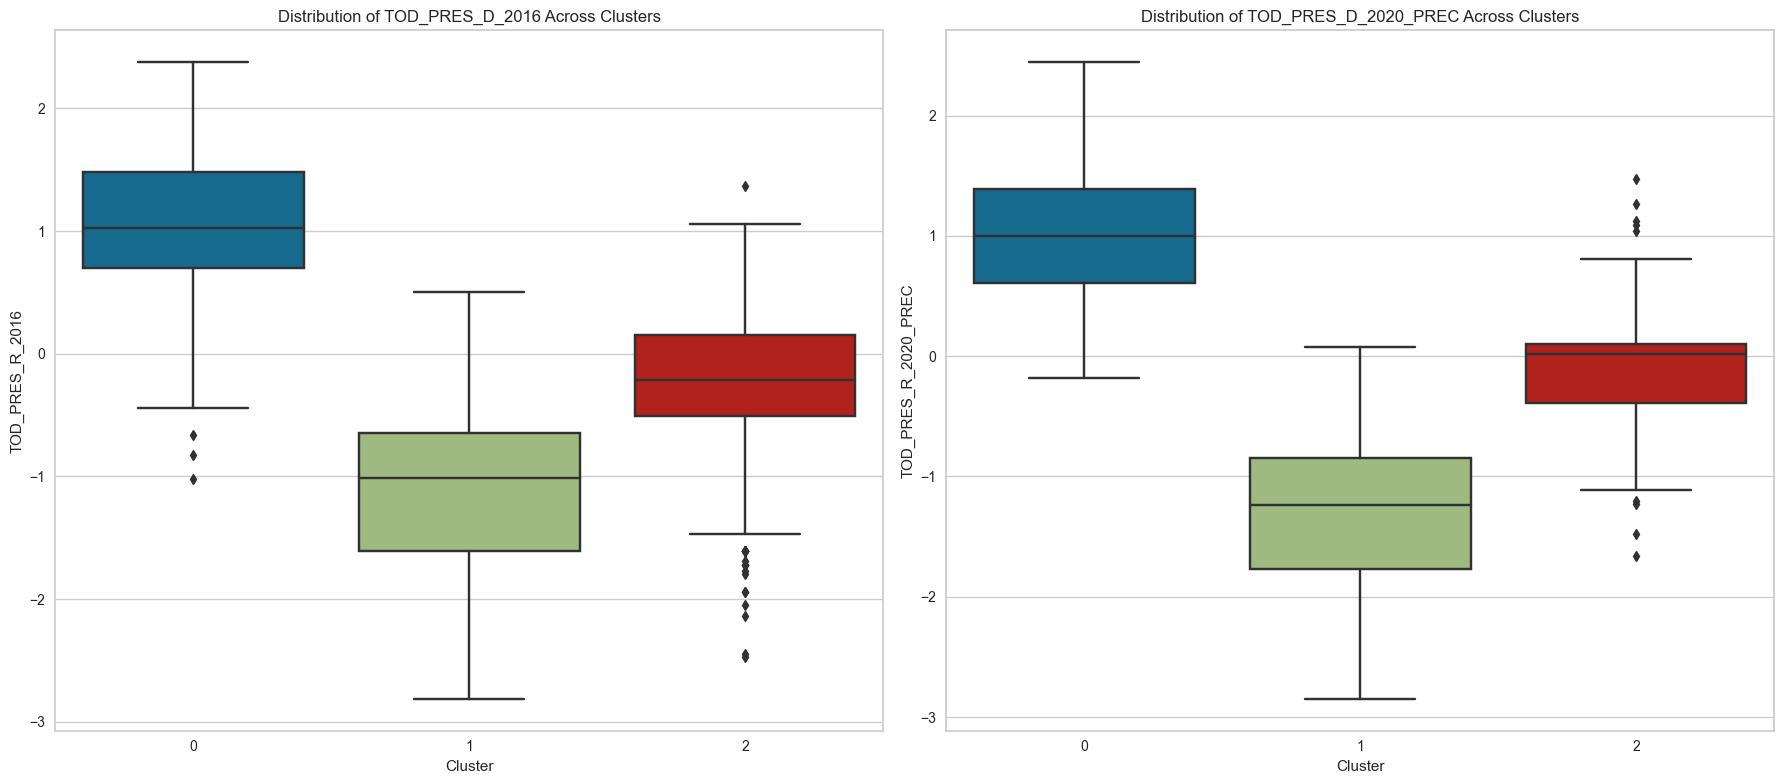

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Add cluster labels to the original standardized DataFrame
scaled_turn_out_df_with_labels = pd.DataFrame(scaled_turn_out_df, columns=turn_out_df.columns)
scaled_turn_out_df_with_labels['Cluster'] = labels
# Boxplot for 2016
sns.boxplot(data=scaled_turn_out_df_with_labels, x='Cluster', y='TOD_PRES_R_2016', ax=axes[0])
axes[0].set_title('Distribution of TOD_PRES_D_2016 Across Clusters')

# Boxplot for 2020
sns.boxplot(data=scaled_turn_out_df_with_labels, x='Cluster', y='TOD_PRES_R_2020_PREC', ax=axes[1])
axes[1].set_title('Distribution of TOD_PRES_D_2020_PREC Across Clusters')

plt.tight_layout()
plt.show()

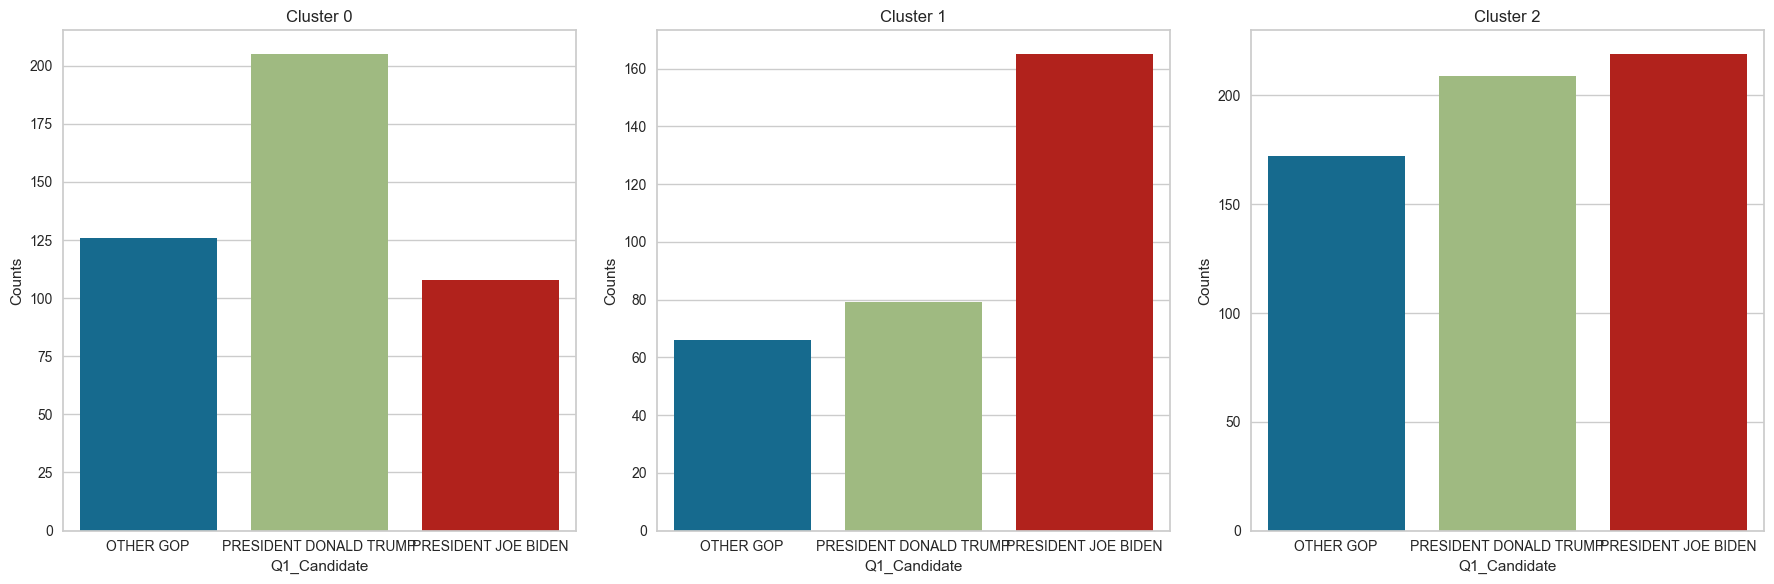

In [86]:
scaled_turn_out_df_with_labels['Q1_Candidate'] = survey_df['Q1_Candidate'].values

count_df = scaled_turn_out_df_with_labels.groupby(['Cluster', 'Q1_Candidate']).size().reset_index(name='Counts')

total_counts = count_df.groupby('Cluster')['Counts'].transform('sum')
count_df['Percentage'] = (count_df['Counts'] / total_counts) * 100


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes.flat):
    subset = count_df[count_df['Cluster'] == i]
    sns.barplot(x='Q1_Candidate', y='Counts', data=subset, ax=ax)
    ax.set_title(f'Cluster {i}')

plt.tight_layout()
plt.show()


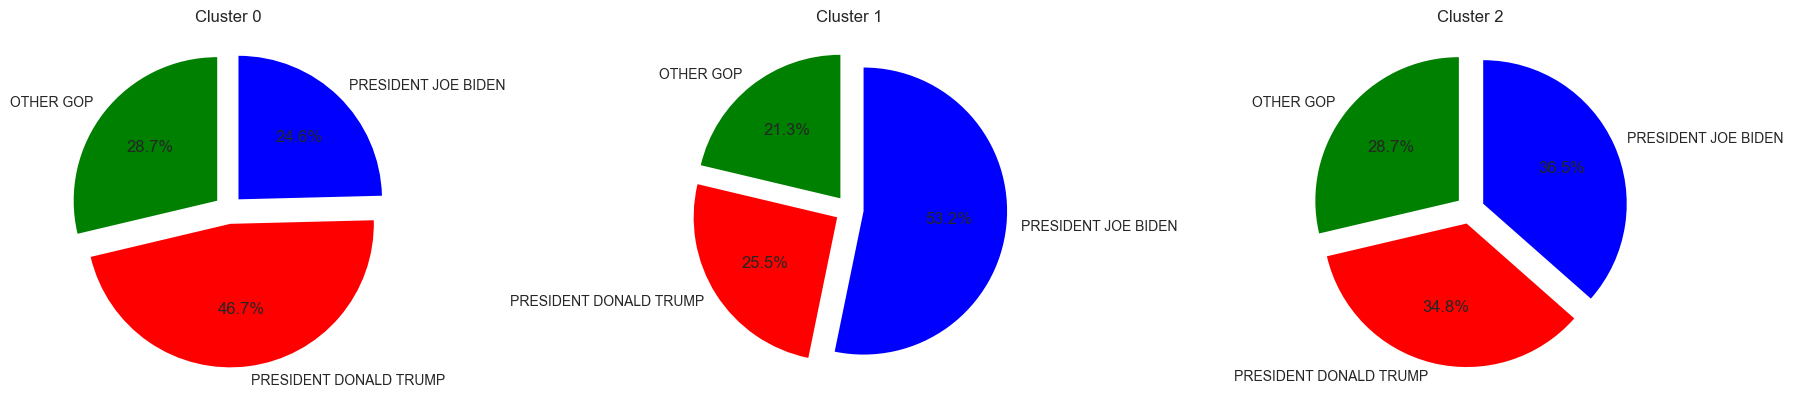

In [158]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Explode parameter
explode = (0.1, 0.1, 0.1)  

for i, ax in enumerate(axes.flat):
    subset = count_df[count_df['Cluster'] == i]
    labels = subset['Q1_Candidate']
    
    # Define the colors based on the labels
    colors = ['blue' if label == 'PRESIDENT JOE BIDEN' else 'red' if label == 'PRESIDENT DONALD TRUMP' else 'green' for label in labels]
    
    ax.pie(subset['Percentage'], labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors)
    ax.set_title(f'Cluster {i}')

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes.flat):
    subset = count_df[count_df['Cluster'] == i]
    sns.barplot(x='Q1_Candidate', y='', data=subset, ax=ax)
    ax.set_title(f'Cluster {i}')

plt.tight_layout()
plt.show()

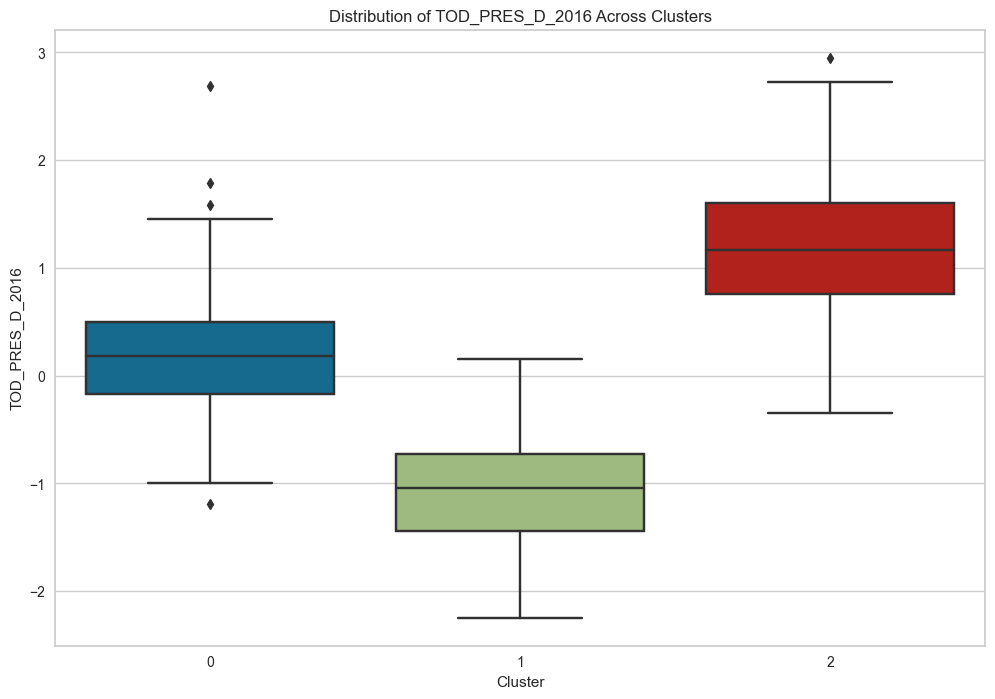

In [74]:
# Add cluster labels to the original standardized DataFrame
scaled_turn_out_df_with_labels = pd.DataFrame(scaled_turn_out_df, columns=turn_out_df.columns)
scaled_turn_out_df_with_labels['Cluster'] = labels

# Boxplot for each feature across clusters
plt.figure(figsize=(12, 8))
sns.boxplot(data=scaled_turn_out_df_with_labels, x='Cluster', y='TOD_PRES_D_2016')
plt.title('Distribution of TOD_PRES_D_2016 Across Clusters')
plt.show()
